<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# Radiomics - 1p/19q Chromosome Status Classification Using Deep Learning

**Special thanks to:**  
- Dr. Bradley J. Erickson M.D., Ph.D. - Department of Radiology - Mayo Clinic
- Dr. Panagiotis Korfiatis, Ph.D. - Department of Radiology - Mayo Clinic
- Dr. Daniel LaChance, M.D. - Department of Neurology - Mayo Clinic

**Acknowledgment**
National Cancer Institute (NCI), *GrantNo. CA160045* and The Cancer Imaging Archive (TCIA)


## Introduction
Diagnosis of a brain tumor can be devastating to patients. Surgery is an essential step in management and can be painful and life-threatening. Often the next steps are radiation and chemotherapy which also have side effects and are expensive. Targeted therapies based on genetic properties of the tumor can improve response and reduce the side effects of treatment.  Thanks to work being performed at Mayo Clinic, new approaches using deep learning techniques to detect biomarkers can lead to more effective treatments and yield better health outcomes.


## Background

Radiogenomics refers to the correlation between cancer imaging features and gene expression. Radiogenomics can be used to identify biomarkers that characterize the genomics of a disease without the use of an invasive biopsy. A biomarker is simply an indicator of some biological state or condition. Four biomarkers that appear important for brain tumors include 1p/19q chromosome co-deletion; MGMT-promoter methylation; IDH-1 mutation; and TERT. The focus of this lab is detection of 1p/19q co-deletion using deep learning, specifically convolutional neural networks. What is remarkable about this research is the novelty and promising results of combining deep learning with Radiogenomics. In addition to avoiding invasive biopsies, the detection or absence of biomarkers is significant because certain treatments of brain tumors are more effective in the presence or absence of a biomarker. Biomarker detection can ensure patients receive the most effective treatment for their particular scenario.

Research has been performed demonstrating the detection of 1p/19q co-deletion using deep learning applied to T2 weighted MRI. **The lab instructions that follow will guide you through one approach to establishing your own convolutional neural network to detect 1p/19q co-deletion biomarker. More specifically we will demonstrate how to create a network that, given an MRI scan, can detect the areas of hyperintensity and classify these areas as 1p/19q codeleted or not.** We will design a classifier that differentiates between slices that contain hyperintensities and, for the slices of the exam that contain hyperintensities, decides if the areas are codeleted or not. 
This eliminates the need for manual tumor delineation during the inference step.
You will experiment with alterations to the network architecture, hyperparameters, and training data. We will investigate the use of small and large networks, implement methods to avoid overfitting and overcome class imbalances.  We encourage you to do such experimentation and to utilize deep learning for the detection of other biomarkers and classification tasks. 


## Getting Started
Before going into details on architecting and training a neural network, there are some housekeeping tasks that need to be executed first.  Examples of such tasks include: 
- Importing libraries
- Setting necessary parameters for reproducibility 

The above list reflects only some of the basic tasks you may need to perform at your site.

Go ahead and place your cursor in each of the three code boxes below and click the **"run cell" button**, or press **Shift+Enter**.

## Load general use libraries 

In [1]:
import os
import sys, logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
np.random.seed(1337) # for reproducibility
from collections import Counter
import shutil

## Load Keras libraries 

We will be using Keras with Tensorflow as backend.

In [2]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from _util import readfile, FindClass, ValidateModel, plot_confusion_matrix, createROCplots
keras.backend.set_floatx('float32')
from keras import backend as K
from keras.models import model_from_json
from keras.models import load_model
from keras.callbacks import Callback
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Set logging level for the tensorflow library. 
from genseq import BlockSequence # Data genenrator, This will provide the data to the classifier. 
from keras.callbacks import TensorBoard
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU                                   
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


## Load sklearn library for evaluation purposes

These libraries will help us calculate the evaluation metrics of our model


In [3]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics as me
from sklearn.metrics import confusion_matrix

## Network Architecture 
The code block that follows defines our network architecture and provides code that visualizes the model's performance.  Notice how easy it is to define a convolution neural network!  Let's take a closer look at some of the layers in the network architecture by exploring the Keras / TensorFlow options used.
<br>
<br>
<br>
**Sequential()**

Immediately after the def cnn_model line below we see the following code: 

`model = Sequential()`

Sequential() is a Keras specification that allows us to create a linear stack of layers in our neural network architecture.
<br>
<br>
<br>
**Conv2D()**

`model.add(Conv2D(16, (3, 3),activation='linear',kernel_initializer='he_uniform'))`

Kernels act like filters.  Each kernel slides over an input image / space to yield a value that projects to a new space (see picture below).  As noted earlier, smaller convolutions offered better results because the smaller convolutions capture some of the finer details of the edges of a tumor.  All convolutional layers in this network use 3 X 3 kernels.  The architecture starts with 16 kernels in a layer, moves to using 32 kernels per layer, then 64 kernels per layer, and reaches a high of 96 kernels per layer.


One of the major advantages of using deep neural networks is that you do not have to define the features yourself.  Convolutions find features in the data for you.  Each kernel needs an initial set of weights. There are numerous approaches to initializing these weights - 'he_uniform' was chosen here.  Feel free to experiment using other weight initialization options.
<br>
<br>
<img src="images/Convolution.png" width="400" height="300">
<br>
<br>
<br>
**ReLU()**

`model.add(ReLU())`

ReLU is one of many activation functions (sigmoid, tanh, etc.) that can be selected. 

<br>
<br>
<br>
**MaxPooling2D()**

`model.add(MaxPooling2D(pool_size=(2, 2)))`

Pooling is a down-sampling technique that reduces the number of computations that must be performed.  Maxpooling identifies the most important feature in a specified area (2 X 2 given the example above) and projects the maximum value onto a new space.  This model initially uses 2 X 2 maxpooling and then uses 5 X 5 maxpooling.
<br>
<br>
<br>
**Flatten()**

`model.add(Flatten())`

Flattens the input into a 1-D layer. Does not affect the number of neurons in the layer, just their arrangement.
<br>
<br>
<br>
**Dense()**

`model.add(Dense(128))`

Dense adds a fully connected layer with a fixed number of neurons.  Dense is used twice to decrease the number of neurons to three just before the softmax layer to reflect what will be the binary prediction of either 'no hyperintensity,' 'co-deletion,' or 'no co-deletion'.
<br>
<br>
<br>
**GaussianNoise()**

`model.add(keras.layers.noise.GaussianNoise(0.2))`

To prevent overfitting of the training data, noise was intentionally added.
<br>
<br>
<br>
**Dropout()**

`model.add(Dropout(0.25))`

Dropout represents yet another means of preventing or limiting overfitting of your model to the training data.  Dropout randomly avoids neurons during the forward and backward propagation phases.  The number of neurons not updating depends upon the value specified inside Dropout().  In this example, one quarter (0.25) of the neurons are skipped.
<br>
<br>
<br>
**Activation('softmax')**

`model.add(Activation('softmax'))`

The last layer in our network, the output layer, uses a softmax activation function to clasify the sample to the correct class 'No hyperintensity','1p/19q co-deletion' and '1p/19q preserved'.

**_Network Architecture Quiz_**

<a name="Network_Architecture_Questions"></a>

[Network Architecture Quiz Answers](#Network_Architecture_Answers)


If you do not know the answer, feel free to search the internet.

**Question 1:**  What are the advantages and disadvantages to having fewer layers?

**Question 2:**  What are the advantages and disadvantages to having fewer neurons?

**Question 3:**  Why might you choose a smaller kernel size and why might you choose a larger kernel size?

**Question 4:**  Is MaxPooling the only type of pooling?

**Question 5:**  What does overfitting mean?

## Set a directory to store the model

In [4]:
logger = logging.getLogger("MainExecutable")
logger.info('{}'.format(K.image_data_format()))
logger.info('{}'.format(K.backend()))
logger.info('{}'.format(str(os.getpid())))
directory='/dli/tasks'
logger.info('Will place output in the following folder: %s'%(directory))
# The following lines of code will create a directory named Results. All our results and models will be placed in this folder. 
if not os.path.exists(directory):
	os.makedirs(directory)

## Use the data generator to load the training and validation data

Instead of loading the whole data set in memory the data generator will read the data in small parts. In this example we will be utilizing a data generator that reads nifti files. The current generator can be easily modified and adapted to read DICOM files as well.

In [5]:
logger.info('Load training/validation')
# Parameters
batchSize=8
sizex=240
sizey=240
n_labels=3
channels=1
biom='pq'
# Set up data generator
TrainSequence = BlockSequence ( dataPath='Train.txt', batchSize=batchSize, sizex=sizex, sizey=sizey,n_labels=n_labels,channels=channels,biom=biom )
ValidationSequence = BlockSequence ( dataPath='Validation.txt', batchSize=batchSize, sizex=sizex, sizey=sizey,n_labels=n_labels,channels=channels,biom=biom )
logger.info('Loading Complete')



## Are our data balanced?
When designing any type of machine learning system it is useful to know how many samples per class our dataset includes.  


In [6]:
with open("Train.txt" ) as f:
		Patients = f.read().splitlines()

labels_train=[]
for subject in Patients:
	imagedata,label=readfile(image_ori=subject,channels=1,biom="pq")
	labels_train.append(label)
logger.debug('{}'.format(str(Counter(labels_train))))
Summary=Counter(labels_train)
Summary['No HyperIntensity'] = Summary.pop(0)
Summary['Not Codeleted'] = Summary.pop(1)
Summary['Codeleted'] = Summary.pop(2)
logger.info('{}'.format(str(Summary)))
print ((Summary))

Counter({'No HyperIntensity': 1721, 'Not Codeleted': 628, 'Codeleted': 248})


<br>


## Hyperparameters
Through the course of this research multiple hyperparameter values were tested.  The code below represents the combination of hyperparameters and their corresponding values that provided the best results.  When experimenting with this architecture or adapting it to your own data you may want to alter the values shown here to see if you get better results.  Let's take a closer look at some of the hyperparameters and code shown in the next code block.
<br>
<br>
<br>
**Batch Size**

The batch size indicates the number of images that are processed at one time during forward propagation to yield a loss value that is used in backpropagation.  Typically batch size is set to a power of two and is limited by the amount of memory available.  Also, though larger batch size may allow for faster training, weights update less frequently and may fail to provide the best results. Smaller batch sizes may require smaller learning rates for stability.
<br>
<br>
<br>
**Number of Epochs**

The number of epochs represents the number of times the entire training dataset is iterated over when training your model.  Validation, performed at the end of each epoch, identifies how well the model generalizes to the validation data (not included in the training process).
<br>
<br>
<br>
**Optimizers and parameters**

Choosing the best optimization algorithm can lead to a neural network model with slightly better and faster results. Common options for the optimizer are:
- Stochastic Gradient Descent (SGD)
- Adam 
- RMS

**Learning rate**
Learning rate is a hyper-parameter that controls how much we are adjusting the weights of our network with respect to the loss gradient. The lower the value, the slower we travel along the downward slope. 


## Optimizer and learning rate

#### Select a value for the leanring rate

In [7]:
initial_learning_rate=0.00001

#### Run this cell to use NADAM optimizer

In [ ]:
opt=keras.optimizers.nadam(lr=initial_learning_rate)

#### Or, run this cell instead to use ADAM optimizer

In [8]:
opt=keras.optimizers.adam(lr=initial_learning_rate)

## Training monitoring 
**ReduceLROnPlateau()**

`lr_reducer = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=np.sqrt(0.1), cooldown=0, patience=2, min_lr=0.5e-6)`

The learning rate represents how much we move in a certain direction in attempt to find the global minima.  Since initial weight values are somewhat arbitrary, starting with a higher learning rate typically works fine.  As we progress through the training phase, we should get closer and closer to either the global or local minimum.  Since we do not want to overshoot the minimum, a common practice is to anneal the learning rate.  In other words, as we progress through the training phase, we start to take smaller and smaller steps in a certain direction. ReduceLROnPlateau() represents one example of how you can anneal the learning rate.  In the code example above, we will keep reducing the learning rate by the square root of 0.1 when there is no change in the loss value as long as the learning rate has not reached a reduction of 5e-7.
<br>
<br>
<br>
**EarlyStopping()**

`early_stopper = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=10)`

Early stopping mechanisms help prevent or limit overfitting models to training data.  Also, early stopping mechanisms prevent unnecessary computations when results remain static.  The model presented here will stop training if for a patience of 10 (epochs) there has not been a change of at least 0.001.
<br>
<br>
<br>

**ModelCheckpoint()**

`    keras.callbacks.ModelCheckpoint( directory+'/weights.{epoch:04d}-{val_loss:.2f}.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)`

ModelCheckpoint will monitor the model and save the weights.

<br>
<br>
<br>

In [9]:
# Callbacks:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience=30, min_lr=0.0000001, verbose=1),
    keras.callbacks.ModelCheckpoint( directory+'/weights.{epoch:04d}-{val_loss:.2f}.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
    keras.callbacks.ModelCheckpoint( directory+'/best.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
    keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.01, patience=100, verbose=0, mode='auto'),
    keras.callbacks.TerminateOnNaN(),
    keras.callbacks.TensorBoard(log_dir=directory+'/tensorboard', histogram_freq=0, write_graph=True, write_images=True)

]

**_Hyperparameter Quiz_**

<a name="Hyperparameter_Questions"></a>

[Hyperparameter Quiz Answers](#Hyperparameter_Answers)


If you do not know the answer, feel free to search the internet.

**Question 1:**  Why would you want to increase the batch size?  Identify one possible concern associated with larger batch sizes.

**Question 2:**  What are two roles early stopping mechanisms play when it comes to building models?

**Question 3:**  Why would you want to increase the number of epochs?  Why would you decrease the number of epochs?

The code below provides values for some of the hyperparameters and creates the datasets.  After going through this lab with the pre-defined values, feel free to come back to this code and alter the hyperparameter values to see if you can improve upon the accuracy of your model.

## Model 1

### The following cell will create  an Inception model. This model is already implemented in the Keras library

In [10]:
from keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(include_top=True, weights=None, input_tensor=None, input_shape=(240,240, 1), pooling=None, classes=3)

### Use a pretrained network to start

In [ ]:
inceptionpretrain = InceptionV3(include_top=True, weights=None, input_tensor=None, input_shape=(240,240, 1), pooling=None, classes=3)
inceptionpretrain.load_weights("inception2.h5")

## Model 2


In [ ]:
# Import some modules
from keras.layers import Conv2D, MaxPooling2D, Input, BatchNormalization, ReLU
from keras.models import Sequential
from keras.layers.core import Flatten, Activation, Dense, Dropout
from keras.layers.core import ActivityRegularization
from keras.layers.advanced_activations import LeakyReLU

def simpleCNN():
    model = Sequential()
    model.add(Conv2D(16, (3, 3),activation='linear',kernel_initializer='he_uniform',
                     input_shape=(240, 240, 1)))
    model.add(BatchNormalization())
    model.add(ReLU())   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(ReLU())   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(ReLU())   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3),activation='linear',kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(ReLU())   # add an advanced activation
    model.add(MaxPooling2D(pool_size=(5, 5)))
    model.add(keras.layers.noise.GaussianNoise(.2))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(ReLU())   # add an advanced activation
    model.add(Dropout(0.25)) # Avoid over-fitting  
    model.add(Dense(3))
    model.add(Activation('softmax'))
    return model
CNN=simpleCNN()

### Use a pretrained network to start
**If you modify the above cell, please skip this code cell or comment the following lines.** 


In [ ]:
CNNpretrain=simpleCNN()
CNNpretrain.load_weights("CNN2.h5")

## Compile the model and Train
The code that follows creates an instance of the previously defined network and will use the previously defined hyperparameter values to compile and fit the model. The fit process will use the previously defined generators to read the data.  Please take a moment to read through the following code before executing as the code reveals several approaches that can be taken in your own research to better understand both the data and the model produced.

- Select one of the following options
    - Use the Simple CNN with or without the weights 
    - Use the Inception network with or without the weights 

### Run ONE of the following 4 cells


#### 1) If you want to use the CNN pretrained network 

In [ ]:
model=CNNpretrain

#### 2) If you want to use the Inception pretrained network 

In [ ]:
model=inceptionpretrain

#### 3) If you want to use the Inception network  (Train from scratch)

In [11]:
model=inception

#### 4) If you want to use the CNN network   (Train from scratch)

In [ ]:
model=CNN

### Lets see how our model looks like

In [12]:
print (model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 119, 119, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 119, 119, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 119, 119, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Train

#### Parameters

In [13]:
epochs=2
class_weight= {0 : 1., 1:3., 2:5.}


In [14]:

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# Class imbalance
# Fit
model.fit_generator(TrainSequence,steps_per_epoch=len(TrainSequence) ,validation_data = ValidationSequence,validation_steps = len(ValidationSequence) 
                              ,epochs=epochs,workers=1, max_queue_size=4,verbose=1,callbacks=callbacks, shuffle=False,class_weight=class_weight)

Epoch 1/2
325/325 [==============================] - 57s 176ms/step - loss: 1.8677 - acc: 0.5106 - val_loss: 0.9914 - val_acc: 0.6354
Epoch 2/2
325/325 [==============================] - 34s 105ms/step - loss: 1.5754 - acc: 0.6755 - val_loss: 0.8610 - val_acc: 0.6736


### Click [here](/tensorboard/) to start TensorBoard.

## Apply model on validation set 
We will calculate:

- the confusion matrix
- Performance metrics (Precision, recall, f1-score)
- ROC curves


Confusion matrix: Validation
Confusion matrix, without normalization
[[134  51  10]
 [ 13  53   6]
 [  5   9   7]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                    precision    recall  f1-score   support

No Hyper Intensity     0.8816    0.6872    0.7723       195
   1p19q preserved     0.4690    0.7361    0.5730        72
   1p19q codeleted     0.3043    0.3333    0.3182        21

       avg / total     0.7364    0.6736    0.6894       288

Summary
Precision:  0.7363510784343507
Recall:  0.6736111111111112
F1 Score:  0.689378679013045


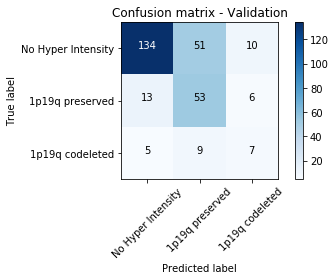

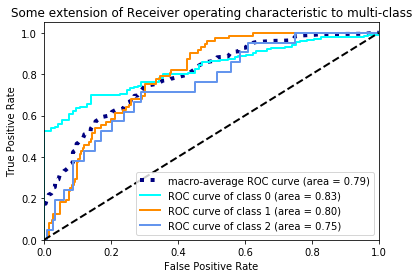

In [15]:
predicted_class, predictedoutput, truth=ValidateModel(model,"Validation.txt")
print('Confusion matrix: Validation')
cm=(confusion_matrix(truth, predicted_class))        
target_names=['No Hyper Intensity', '1p19q preserved', '1p19q codeleted' ]
plot_confusion_matrix(cm, target_names,
                          normalize=False,
                          title='Confusion matrix - Validation',
                          cmap=plt.cm.Blues)
print ("The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.")
print(me.classification_report( truth, predicted_class, target_names=target_names,digits=4))

print ('Summary')
print ("Precision: ", (me.precision_score( truth, predicted_class,average='weighted')))
print ("Recall: ", (me.recall_score( truth, predicted_class,average='weighted')))
print ("F1 Score: ", me.f1_score( truth, predicted_class,average='weighted'))


createROCplots(truth, predictedoutput )

## Apply model on test set 
We will calculate:

- the confusion matrix
- Performance metrics (Precission, recall, f1-score)
- ROC curves
It is important to note that the performance during the validation and testing phase must not differ significantly.


Confusion matrix: Test
Confusion matrix, without normalization
[[75 28  4]
 [13 64  5]
 [ 7 14 10]]
The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.
                    precision    recall  f1-score   support

No Hyper Intensity     0.7895    0.7009    0.7426       107
   1p19q preserved     0.6038    0.7805    0.6809        82
   1p19q codeleted     0.5263    0.3226    0.4000        31

       avg / total     0.6832    0.6773    0.6713       220

Precision:  0.6831768529385213
Recall:  0.6772727272727272
F1 Score:  0.6712965126299864


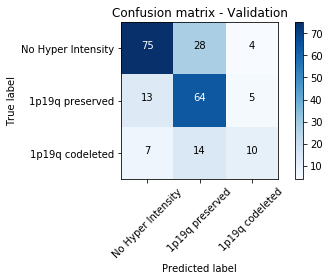

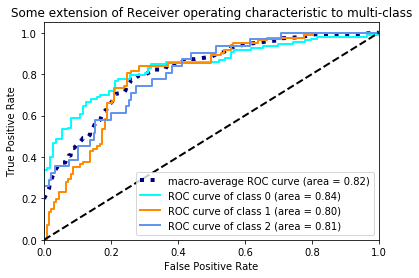

In [16]:
predicted_class, predictedoutput, truth=ValidateModel(model,"Test.txt")
print('Confusion matrix: Test')
cm=(confusion_matrix(truth, predicted_class))        
target_names=['No Hyper Intensity', '1p19q preserved', '1p19q codeleted' ]
plot_confusion_matrix(cm, target_names,
                          normalize=False,
                          title='Confusion matrix - Validation',
                          cmap=plt.cm.Blues)
print ("The f1-score gives you the harmonic mean of precision and recall. The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.The support is the number of samples of the true response that lie in that class.")

print(me.classification_report( truth, predicted_class, target_names=target_names,digits=4))
print ("Precision: ", (me.precision_score( truth, predicted_class,average='weighted')))
print ("Recall: ", (me.recall_score( truth, predicted_class,average='weighted')))
print ("F1 Score: ", me.f1_score( truth, predicted_class,average='weighted'))


createROCplots(truth, predictedoutput )

## Can you do better? 

Try to create your own model and run cross validation 


 - Add/remove layers<br>
     For example:
     - model.add(Conv2D(8, (3, 3)))
     - model.add(Conv2D(16, (3, 3),activation='tanh',kernel_initializer='he_uniform')
     * Adjust maxpooling accordingly 
     [extra help](https://keras.io/layers/core/)
     
     
 - Try different optimizers <br>
     For example: Adam, SGD 
     - altoptimizer=keras.optimizers.SGD(lr=0.0001)
     - altoptimizer=keras.optimizers.Adam(lr=0.0001)
         - Change the learning rate:
you can choose values between .1 to 2e-6
     [extra help](https://keras.io/optimizers/)
            
     
 - Change convolution size <br>
     For example:
     - model.add(Conv2D(8, (5, 5)))


## Inference: Apply the model on a T2 weighted scan
Once you believe you have captured the best model, then it is time to evaluate a final set of results using all the data to ensure that the model's precision, recall, and accuracy are at their optimum on the test set.  



The correct class is  2


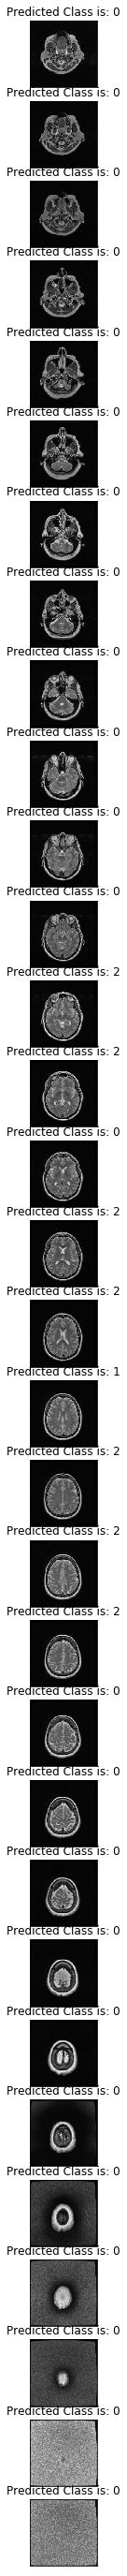

In [17]:
# Read a nifti file
testcase='TESTCASE1_trueclass1.nii.gz'

# testcase='TESTCASE2_trueclass1.nii.gz'

imagedata,label=readfile(image_ori=testcase,channels=1,biom="trueclass", test=True)

print ('The correct class is ', FindClass(testcase, start='trueclass', end='.nii.gz'))
# Load the model 
loaded_model = load_model(directory+'/best.h5')
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
# Change the shape of the array to much the one our classifier requires
imagedata=np.swapaxes(imagedata,2,1)
imagedata=np.swapaxes(imagedata,1,0)
# Apply the classifier 
imagedata=imagedata.reshape(-1,240,240,1)
prediction = loaded_model.predict(imagedata)
# print ('-----')
prediction= np.argmax(prediction, axis=1)
# print ('prediction')
# print (prediction)
# print ('---')
plt.figure(figsize=(50,50))    
number_of_subplots=np.shape(imagedata)[0]

for i,v in enumerate(range(number_of_subplots)):
    v = v+1
    ax1 = plt.subplot(number_of_subplots,1,v)
    ax1.set_title("Predicted Class is: "+str(prediction[i]))
    ax1.imshow(np.rot90(imagedata[i,:,:,0]), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
plt.show()


## What Next
Many ways to explore and possibly improve the model:

- Add additional layers to the network

- Change the number of neurons in those layers

- Change some of the hyperparameters in the network configuration like dropout or learning rate, etc.


Time permitting, go back to the code above and experiment with some of these suggested changes to see if you can achieve better results.

## Network Architecture Quiz Answers

<a name="Network_Architecture_Answers"></a>

[Network Architecture Quiz Questions](#Network_Architecture_Questions)

**Question 1:**  What are the advantages and disadvantages to having fewer layers?
<br>
<br>
**_Answer:_**  Fewer layers have fewer computations that must be performed which leads to faster training times.  However, it may also prevent the discovery of higher and higher level features that leads to more accurate models if more layers were included in the network architecture.
<br>
<br>
**Question 2:**  What are the advantages and disadvantages to having fewer neurons?
<br>
<br>
**_Answer:_**  Fewer neurons means that you have fewer features.  Fewer features may yield models with lower than expected accuracy levels.  Alternatively, if a smaller number of features yields acceptable levels of accuracy, then the reduced number of computations should yield faster training times.
<br>
<br>
**Question 3:**  Why might you choose a smaller kernel size and why might you choose a larger kernel size?
<br>
<br>
**_Answer:_**  Smaller kernel sizes may be better at capturing some of the finer details of an image that would otherwise be lost if larger kernel sizes were selected.  This could lead to a model that does not reach an acceptable level of accuracy.  Alternatively, larger kernel sizes reduce the number of computations being performed; thus, leading to shorter training times.  If a higher degree of information loss can be afforded, using larger kernel sizes may be desirable given the reduction in training time.  
<br>
<br>
**Question 4:**  Is MaxPooling the only type of pooling?
<br>
<br>
**_Answer:_**  There are other types of pooling such as Average Pooling, but MaxPooling is the most commonly used type of pooling.
<br>
<br>
**Question 5:**  What does overfitting mean?
<br>
<br>
**_Answer:_**  Overfitting occurs when the features identified during the training process are so specific to the training data that the resulting model does not generalize well to new data where the features may vary.

## Hyperparameter Quiz Answers

<a name="Hyperparameter_Answers"></a>

[Hyperparameter Quiz Questions](#Hyperparameter_Questions)


**Question 1:**  Why would you want to increase the batch size?  Identify one possible concern associated with larger batch sizes.
<br>
<br>
**_Answer:_**  Larger batch sizes result in faster training because backpropagation does not take place as often.  Researchers typically set batch size to the maximum number of images that can be held in memory without generating an "Out of Memory" error message.  Also, it is common to have the batch size set to a value that is a power of 2, but this is not a requirement.  The possible drawback to a larger batch size is that the weights are not updated as frequently which may result in a model that is not as accurate.  However, it may also mean that model is less likely to be overfitted to the training data.
<br>
<br>
**Question 2:**  What are two roles early stopping mechanisms play when it comes to building models?
<br>
<br>
**_Answer:_**  Early stopping mechanisms, where training ceases prematurely, can help limit or prevent overfitting the model to the training data and can also help conserve GPU resources.
<br>
<br>
**Question 3:**  Why would you want to increase the number of epochs?  Why would you decrease the number of epochs?
<br>
<br>
**_Answer:_**  Increasing the number of epochs may improve the accuracy of the model.  However, it may also lead to overfitting the model to the training data.  Experimentation with this hyperparameter along with the use of early stopping mechanisms are typical approaches to getting to an acceptable epoch value. Reviewing the loss curves during validation phase c help as well.  


<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>